In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pattrex.plotting_mpl as plt_rex
import pattrex.preprocessing as pre_rex

from pattrex.demo_helper import read_whdata

In [6]:
# Read data, remove and save outliers
ws, hs, gs = read_whdata()
HW = np.vstack((hs, ws)).astype(np.float)
HW_new, neg_idx = pre_rex.only_all_positive(HW, True, return_neg_idx=True)
H_unknown = np.array([h for i, h in enumerate(hs) if i in neg_idx])

hn = HW_new[0, :]
wn = HW_new[1, :]

## Bayesian Regression ala `sklearn`

In [5]:
from sklearn.linear_model import BayesianRidge

In [8]:
from numpy.polynomial.polynomial import polyvander

In [124]:
d = 5

hnv = polyvander(hn, d)

In [144]:
clf = BayesianRidge(verbose=True)
clf.fit(hnv, wn)

Convergence after  3  iterations


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=True)

In [126]:
W = clf.coef_
W

array([  0.00000000e+00,  -8.58396734e-09,  -1.46782148e-06,
        -1.25505530e-04,   1.43678494e-06,  -3.75820142e-09])

In [127]:
huv = polyvander(H_unknown, d)

In [128]:
w_pred = clf.predict(huv)
w_pred

array([ 62.41376747,  69.04774152,  60.76112354])

In [160]:
clf.get_params()

{'alpha_1': 1e-06,
 'alpha_2': 1e-06,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 1e-06,
 'lambda_2': 1e-06,
 'n_iter': 300,
 'normalize': False,
 'tol': 0.001,
 'verbose': True}

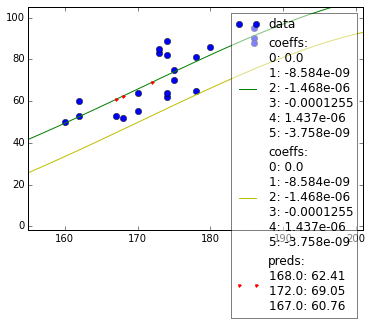

In [99]:
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
HW_ = np.vstack((hs, ws))  # only the measurements; data is col-wise
xmin, ymin = HW_.min(axis=1)
xmax, ymax = HW_.max(axis=1)

xlim = [xmin-5, xmax+15]  # purely for looks
ylim = [-2, ymax+10]

# generate data for the fitted solution
h = np.linspace(hn.min()-5, hn.max()+15)
h_ = polyvander(h, d)
w = clf.predict(h_)

ww = np.dot(h_, W)

plt_rex.plot2d(HW_new, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
               show=False, axs=axs, plotlabel="data")

plt_label = "coeffs:\n" + "\n".join("{}: {:.4}".format(*c) for c in enumerate(W))
plt_rex.plot2d(np.vstack((h, w)), colwise_data=True, hatch='g', 
               show=False, axs=axs, plotlabel=plt_label)

plt_rex.plot2d(np.vstack((h, ww)), colwise_data=True, hatch='y', 
               show=False, axs=axs, plotlabel=plt_label)

plt_label = "preds:\n" + "\n".join("{}: {:.4}".format(*c) for c in zip(H_unknown, w_pred))
plt_rex.plot2d(np.vstack((H_unknown, w_pred)), colwise_data=True, hatch='r.', 
               show=False, axs=axs, plotlabel=plt_label)

***

In [60]:
x = np.random.uniform(-5, 5, 100)
y = np.power(x, 2) + np.random.uniform(-0.5, 0.5, 100)
x = np.hstack((x, np.array([0.1, 0.2])))
y = np.hstack((y, np.array([10, 15])))

In [61]:
clff = BayesianRidge()
x_ = polyvander(x, 5)

clff.fit(x_, y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [62]:
clff.coef_

array([  0.00000000e+00,   1.55387000e-01,   8.36027832e-01,
        -1.98701332e-02,   5.69918013e-03,   5.98225436e-04])

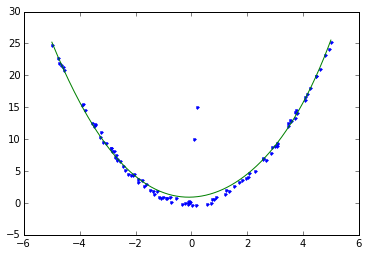

In [63]:
plt.plot(x, y, '.')

xx = np.linspace(-5, 5, 200)
xx_ = polyvander(xx, 5)
yy = clff.predict(xx_)

plt.plot(xx, yy)

## On our own

In [234]:
d = 5
x = np.copy(hn)
X = polyvander(x, d)

y = np.copy(wn)

In [235]:
sig2 = np.var(y)

sig2_0 = 3
mu_0 = 0

XtX = np.dot(np.transpose(X), X)
XtX
print(sig2)

209.011337868


In [236]:
print(sig2)

209.011337868


In [237]:
Prec = (1/sig2) * XtX + (1/sig2_0) * np.eye(d+1)
Prec

array([[  4.33806352e-01,   1.74392453e+01,   3.03222307e+03,
          5.28136436e+05,   9.21464030e+07,   1.61047184e+10],
       [  1.74392453e+01,   3.03255640e+03,   5.28136436e+05,
          9.21464030e+07,   1.61047184e+10,   2.81945437e+12],
       [  3.03222307e+03,   5.28136436e+05,   9.21464033e+07,
          1.61047184e+10,   2.81945437e+12,   4.94434066e+14],
       [  5.28136436e+05,   9.21464030e+07,   1.61047184e+10,
          2.81945437e+12,   4.94434066e+14,   8.68513904e+16],
       [  9.21464030e+07,   1.61047184e+10,   2.81945437e+12,
          4.94434066e+14,   8.68513904e+16,   1.52814106e+19],
       [  1.61047184e+10,   2.81945437e+12,   4.94434066e+14,
          8.68513904e+16,   1.52814106e+19,   2.69315357e+21]])

In [238]:
mu = (1/sig2) * np.dot(np.linalg.pinv(Prec), np.dot(np.transpose(X), y))
mu

array([ -1.90109772e-10,  -1.97395524e-08,  -1.70906136e-06,
        -9.87458994e-05,   1.21689161e-06,  -3.27789493e-09])

In [241]:
w_map = np.dot(np.linalg.pinv(XtX + (sig2/sig2_0) * np.eye(d+1)), 
               np.dot(np.transpose(X), y))

w_map

array([ -1.90109772e-10,  -1.97345627e-08,  -1.70906136e-06,
        -9.87458994e-05,   1.21689161e-06,  -3.27789493e-09])

In [242]:
w_map2 = np.dot(np.dot(np.linalg.inv(XtX + (sig2/sig2_0) * np.identity(d+1)), 
               np.transpose(X)), y)

w_map2

array([  1.75403490e-04,   8.64614411e-03,   3.63943932e-01,
        -6.39907782e-03,   3.75122803e-05,  -7.28705301e-08])

In [244]:
w_map3 = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + (sig2/sig2_0)
                                    * np.identity(d+1)), X.T), y)

w_map3

array([  1.75403490e-04,   8.64614411e-03,   3.63943932e-01,
        -6.39907782e-03,   3.75122803e-05,  -7.28705301e-08])

In [245]:
import scipy.sparse.linalg as sla

w_map = sla.lsmr(X, y, damp=(sig2/sig2_0))
w_map

(array([  4.56663105e-16,   6.41471521e-14,   8.46043977e-12,
          9.93344809e-10,   8.75977569e-08,  -5.48878150e-11]),
 2,
 2,
 39.06160933154306,
 804293.24618307676,
 750278470980.438,
 4353.7301832225294,
 8.7603406459642545e-08)

In [181]:
from scipy.stats import norm

In [247]:
np.dot(polyvander(H_unknown, d), mu)

array([ 62.43027909,  69.08218301,  60.76849986])

[[ 62.43027909]
 [ 69.08218301]
 [ 60.76849986]]


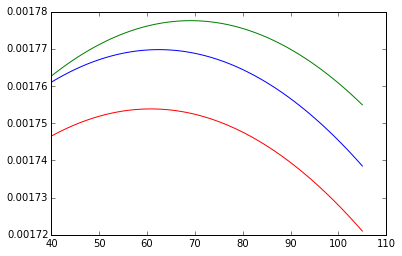

In [248]:
w_pred2 = []

mu_t = np.transpose(mu)
Prec_inv = np.linalg.pinv(Prec)
for hu in H_unknown:
    huv = np.transpose(polyvander(hu, d))
    
    mean = np.dot(mu_t, huv)
    sigma = sig2 + np.dot(np.transpose(huv), np.dot(Prec_inv, huv))
    
    y = np.linspace(wn.min()-10, wn.max()+10, 100)
    pdf = np.transpose(norm.pdf(y, mean, sigma))
    
    plt.plot(y, pdf)
    
#     w_pred2.append(y[np.argmax(pdf)])
    w_pred2.append(mean)
    
w_pred2 = np.array(w_pred2)
print(w_pred2)

In [231]:
def predict(huv_):
    w_pred2 = []
    for hu in huv_:
        huv = np.transpose(hu)

        mean = np.dot(mu_t, huv)
        sigma = sig2 + np.dot(np.transpose(huv), np.dot(Prec_inv, huv))
        print(sigma)

        y = np.linspace(wn.min()-10, wn.max()+10, 100)
        pdf = np.transpose(norm.pdf(y, mean, sigma))
        
        pred = y[np.argmax(pdf)]
        w_pred2.append(mean)
        
        print(pred, mean)
        
    return np.array(w_pred2)

403.548576959
41.3131313131 41.3716858896
375.984963654
42.6262626263 42.8318694606
351.146434297
44.595959596 44.3044834125
328.965181828
45.9090909091 45.788836182
309.355970138
47.2222222222 47.2842109616
292.216652204
48.5353535354 48.789865413
277.428888497
50.5050505051 50.3050313807
264.85908186
51.8181818182 51.8289146045
254.359545679
53.1313131313 53.3606944333
245.769922906
55.101010101 54.899523538
238.918874237
56.4141414141 56.4445276248
233.626054429
57.7272727273 57.9948051482
229.704396571
59.696969697 59.5494270246
226.962724842
61.0101010101 61.107436345
225.208717108
62.9797979798 62.6678480885
224.252239539
64.2929292929 64.2296488357
223.909076169
65.6060606061 65.7917964811
224.005077299
67.5757575758 67.3532199475
224.380751397
68.8888888889 68.9128188979
224.896326075
70.202020202 70.4694634497
225.437304605
72.1717171717 72.0219938874
225.920545395
73.4848484848 73.5692203759
226.300892731
74.797979798 75.1099226739
226.578388049
76.7676767677 76.6428498466
22

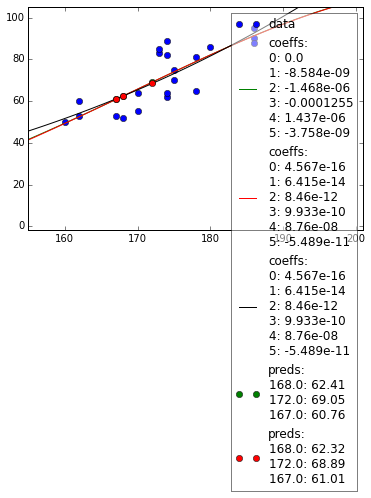

In [232]:
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
HW_ = np.vstack((hs, ws))  # only the measurements; data is col-wise
xmin, ymin = HW_.min(axis=1)
xmax, ymax = HW_.max(axis=1)

xlim = [xmin-5, xmax+15]  # purely for looks
ylim = [-2, ymax+10]

# generate data for the fitted solution
h = np.linspace(hn.min()-5, hn.max()+15)
h_ = polyvander(h, d)
w = clf.predict(h_)
w2 = predict(h_)

ww = np.dot(h_, np.transpose(W))
w_map = w_map[0]
ww2 = np.dot(h_, np.transpose(w_map))

plt_rex.plot2d(HW_new, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
               show=False, axs=axs, plotlabel="data")

plt_label = "coeffs:\n" + "\n".join("{}: {:.4}".format(*c) for c in enumerate(W))
plt_rex.plot2d(np.vstack((h, w)), colwise_data=True, hatch='g', 
               show=False, axs=axs, plotlabel=plt_label)

plt_label = "coeffs:\n" + "\n".join("{}: {:.4}".format(*c) for c in enumerate(w_map))
plt_rex.plot2d(np.vstack((h, w2)), colwise_data=True, hatch='r', 
               show=False, axs=axs, plotlabel=plt_label)

# plt_rex.plot2d(np.vstack((h, ww)), colwise_data=True, hatch='y', 
#                show=False, axs=axs, plotlabel=plt_label)

plt_rex.plot2d(np.vstack((h, ww2)), colwise_data=True, hatch='k', 
               show=False, axs=axs, plotlabel=plt_label)


plt_label = "preds:\n" + "\n".join("{}: {:.4}".format(*c) for c in zip(H_unknown, w_pred))
plt_rex.plot2d(np.vstack((H_unknown, w_pred)), colwise_data=True, hatch='go', 
               show=False, axs=axs, plotlabel=plt_label)

plt_label = "preds:\n" + "\n".join("{}: {:.4}".format(*c) for c in zip(H_unknown, w_pred2))
plt_rex.plot2d(np.vstack((H_unknown, w_pred2)), colwise_data=True, hatch='ro', 
               show=False, axs=axs, plotlabel=plt_label)


### pdf

In [349]:
n = 100
padding = 10

data_min = np.array([x.min(), y.min()])
data_max = np.array([x.max(), y.max()])
xy_steps = (data_max - data_min) / (n + 2 * padding)
# noinspection PyPep8
xx, yy = np.mgrid[data_min[0] - padding: data_max[0] + padding:
xy_steps[0],
       data_min[1] - padding: data_max[1] + padding:
       xy_steps[1]]

pdf = []

In [350]:
x = xx[:, 0]

In [351]:
y = yy[0, :]

In [352]:
for i, x_ in enumerate(x):
    x_v = polyvander(x_, d)
    
    mean = np.dot(x_v, mu)
    var = sig2 + np.dot(x_v.T, np.dot(x_v, Prec_inv))
    
    pdf_ = norm.pdf(y, mean, sigma).T
    
    pdf.append(pdf_)

In [353]:
pdf = np.array(pdf)[:, :, 0]

In [354]:
xx.shape

(143, 140)

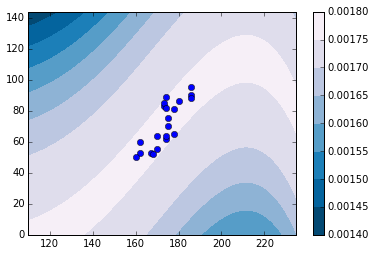

In [362]:
plt.contourf(xx, yy, pdf, cmap=plt.cm.PuBu_r)
plt.colorbar()
plt.plot(hn, wn, 'o')